In [27]:
#imports
import sys
import os
os.chdir(os.path.dirname(os.getcwd()))
import numpy as np
# import torch
from util.methods import *
import matplotlib.pyplot as plt
from astropy.io import fits

plt.style.use("root")

# this allows plots to appear directly in the notebook
%matplotlib inline

# Step 1: Raw track reconstruction

Run GPDSW reconstruction on the raw fits files, this step is the same for simulated and real (calibration) data. This requires up to date GPDSW and GPDEXT software from the [IXPE bitbucket](https://bitbucket.org/ixpesw/workspace/projects/IGS).

**We do not provide the whole of GPDSW and GPDEXT in this repository, this must be installed independently by the user.**

## Real (calibration) data

Example gpdsw commands for reconstructing real data.

```
cd gpdsw/
source setup.sh

cd bin/
./ixperecon 
        --write-tracks 
        --input-files example/data/4p51keV_pol.fits 
        --threshold 20
        --output-folder example/data
        --n 50000
```

## Simulated Data


Example gpdsw commands for simulating and reconstructing simulated data.

I recommend simulating tracks from spectral files, e.g. `flat.txt` shown below and saved in `example/data`. This is much more efficient than simulating multiple line sources.

`gpdswpy/fitsplit.py` splits the simulated fits file into two parts (one part with the monte carlo data `"_mc.fits"` and one with the rest `".fits"`) to make ixperecon run faster (otherwise it is prohibitively slow for simulated data).

Since the final `sim_spec_recon.fits` file produce by ixperecon and `"_mc.fits"` contain all the data, we can delete the original `".fits"` file to save space.

```
cd gpdsw/
source setup.sh

cd bin/
./ixpesim -n 50000 
            --random-seed 194 
            --output-file example/data/sim_spec.fits 
            --log-file example/data/sim_spec.log 
            --src-spectrum user 
            --src-spec-file example/data/flat.txt 
            --src-pol-degree 0 
            --src-pol-angle 0 
            --dme-pressure 687 

cd ..
python gpdswpy/fitsplit.py example/data/sim_spec.fits 

cd bin/ 
./ixperecon --write-tracks 
            --input-files example/data/sim_spec.fits
            --threshold 20
            --output-folder example/data/ 
            
rm example/data/sim_spec.fits

```

# Step 2: Hexagonal -> Square

Transform the fits files of hexagonal tracks into square tracks for the NNs to use. The final products of this step are directories containing:
* ```tracks_full.pickle``` (Containing sparse representations of square tracks to be read by the NNs)
* ```labels_full.pt``` (Containing all of the track metadata -- angles_simulated, angles_moments, energies, abs_pts_simulated, abs_pts_moments, ...  )

This step is handled by ```run_build_fitsdata.py```, which contains multiple options for designing a simulated or real square dataset from hexagonal fits files.

In [2]:
!python3 run_build_fitsdata.py -h

usage: run_build_fitsdata.py [-h] [--augment {1,3,6}] [--npix {30,50}] [--sim]
                             [--tot TOT] [--peak_only] [--tailvpeak TAILVPEAK]
                             input_file out_base

positional arguments:
  input_file            input folder or file
  out_base              output folder

optional arguments:
  -h, --help            show this help message and exit
  --augment {1,3,6}     Number of Track augmentation randomly distributed in
                        dataset. These should always be 6 during inference and
                        1 during training
  --npix {30,50}        Number of pixels in square conversions. This should be
                        50 for v2.0.
  --sim                 Whether to incorporate monte carlo simulated data, not
                        strictly necessary.
  --tot TOT             The total number of tracks to convert to square
  --peak_only           No low or high Z tail tracks
  --tailvpeak TAILVPEAK
                        

## Make measured square dataset

In [24]:
#Measured (calibration) data or simulated data.

!python3 run_build_fitsdata.py example/data/4p51keV_pol_recon.fits example/data/meas4p51

Total number of unique tracks = 50000

Directory already exists
No Monte Carlo, measured data only 

50000 loaded ok

 Beginning hex -> square conversion 

0 of 50000 tracks constructed.
2500 of 50000 tracks constructed.
5000 of 50000 tracks constructed.
7500 of 50000 tracks constructed.
10000 of 50000 tracks constructed.
12500 of 50000 tracks constructed.
15000 of 50000 tracks constructed.
17500 of 50000 tracks constructed.
20000 of 50000 tracks constructed.
22500 of 50000 tracks constructed.
25000 of 50000 tracks constructed.
27500 of 50000 tracks constructed.
30000 of 50000 tracks constructed.
32500 of 50000 tracks constructed.
35000 of 50000 tracks constructed.
37500 of 50000 tracks constructed.
40000 of 50000 tracks constructed.
42500 of 50000 tracks constructed.
45000 of 50000 tracks constructed.
47500 of 50000 tracks constructed.
Final size:  torch.Size([50000])
Flagged 34 tracks.
Finished 

Saved,  example/data/meas4p51


# Step 3: Deep Ensemble


Run square track datasets through the deep ensemble of NNs. **This requires a GPU available (the more the merrier).**
This step is run with ```run_ensemble_eval.py```; the results are saved in a fits file specified with ```save_name```.

**Notes:**
* I suggest playing with the `--batch_size` parameter if the code is throwing GPU memory based errors. It should always be a factor of 2, e.g. 512, 1024, 2048, 4096. Higher batch size means faster runtime but more memory usage on the GPUs. You should try to make it as large as possible before a memory error is thrown.

In [5]:
!python3 run_ensemble_eval.py -h

usage: run_ensemble_eval.py [-h] [--data_list DATA_LIST [DATA_LIST ...]]
                            [--batch_size BATCH_SIZE] [--nworkers NWORKERS]
                            [--datatype {meas,sim}]
                            [--stokes_correct {2.0,2.3,2.7,3.1,3.7,5.9}]
                            save_name

positional arguments:
  save_name             Save Net FoV results in Pandas dataframe with this
                        name

optional arguments:
  -h, --help            show this help message and exit
  --data_list DATA_LIST [DATA_LIST ...]
                        List of Data to evaluate on
  --batch_size BATCH_SIZE
                        Batch size to use for NN evaluation, lower if out of
                        memory error. Maximum possible size should be used to
                        maximize speed.
  --nworkers NWORKERS   Number cpu processes that load data to gpus, should
                        always be <= ngpus and <= ncpus or it may slow things
                 

### Measured Data


In [2]:
#Run tracks through deep ensemble (requires GPU available)
print("Number of GPUs available: {}\n".format(torch.cuda.device_count()))

!python3 run_ensemble_eval.py nn_4p51 --data_list example/data/meas4p51/ --batch_size 1024 --seed 42

Number of GPUs available: 2

Evaluating using ensemble: 
 v2.0

 6 NNs in the ensemble 

>> Angular NN 1/3 : 

Loading full dataset into memory

Dataset:  /home/groups/rwr/alpv95/tracksml/example/data/meas4p51/
Dataset size:  50000
NN on GPU 

=> loading checkpoint '/home/groups/rwr/alpv95/tracksml/net_archive/68720aeff_peakonly_mserrall3_O1gpu/models/mom_1024_110.ptmodel'
Let's use 2 GPUs!
Evaluating on GPU 

0 of 50000 reconstructed.
>> Complete
>> Angular NN 2/3 : 

Loading full dataset into memory

Dataset:  /home/groups/rwr/alpv95/tracksml/example/data/meas4p51/
Dataset size:  50000
NN on GPU 

=> loading checkpoint '/home/groups/rwr/alpv95/tracksml/net_archive/68720aeff_peakonly_mserrall3_O1gpu/models/RLRP_512_90.ptmodel'
Let's use 2 GPUs!
Evaluating on GPU 

0 of 50000 reconstructed.
>> Complete
>> Angular NN 3/3 : 

Loading full dataset into memory

Dataset:  /home/groups/rwr/alpv95/tracksml/example/data/meas4p51/
Dataset size:  50000
NN on GPU 

=> loading checkpoint '/home/gr

# Step 4: Analyze results / Postprocess


Full results from the deep ensembles and moment analysis are saved in a single fits file, just like the moment analysis `_recon.fits`.

## Loading results for analysis

In [19]:
with fits.open('/Users/jtd/Documents/research/IXPEML/example/data_02001399_recon___nn_msh__ensemble.fits', memmap=False) as hdu:
    meas_results = hdu[1].data

In [20]:
meas_results.columns

ColDefs(
    name = 'NN_PHI'; format = 'E'
    name = 'MOM_PHI'; format = 'E'
    name = 'MOM_ELLIP'; format = 'E'
    name = 'NN_WEIGHT'; format = 'E'
    name = 'NN_ABS'; format = '2E'; dim = '(2)'
    name = 'MOM_ABS'; format = '2E'; dim = '(2)'
    name = 'XY_MOM_ABS'; format = '2E'; dim = '(2)'
    name = 'NN_ENERGY'; format = 'E'
    name = 'XY_NN_ABS'; format = '2E'; dim = '(2)'
    name = 'MOM_ENERGY'; format = 'E'
    name = 'TRG_ID'; format = 'J'
    name = 'NN_WEIGHT_EPIS'; format = 'E'
    name = 'P_TAIL'; format = 'E'
    name = 'FLAG'; format = 'J'
    name = 'DIRECTION_FLAG'; format = 'J'
)

**New for v2.0:** 'P_TAIL' gives the predicted tail track probability (probability that the event converted inside the Be window or the GEM). This can be used to cut events at the desired threshold to improve the energy resolution and modulation factor calibration. We show an example below for the energy histograms.

'DIRECTION_FLAG' notes if the NNs were unable to assign a track direction (along the principle axis) for this event. These events have a randomly assigned direction (+ or - along the predicted principal axis). The fraction of events with out a direction will increase with lower energy.

## Analyse polarization results with weighted Stokes' analysis

`util/methods.py' contains the majority of our polarization analysis functions, including weighted Stokes parameters.

(mu, theta0, Neff, mu_err, theta0_err)
NN 0.03053, 1.46, 5e+04, 0.006323, 0.1036,
MDP99: 62.85 

Mom 0.01701, -0.6313, 5e+04, 0.006324, 0.1859,
MDP99: 112.8

 Weighted:
(mu, theta0, Neff, mu_err, theta0_err)
NN 0.01931, -1.488, 4.039e+04, 0.007036, 0.1822,
MDP99: 110.5 

Mom 0.0298, -0.1978, 9.367e+03, 0.01461, 0.2452,
MDP99: 148.7 



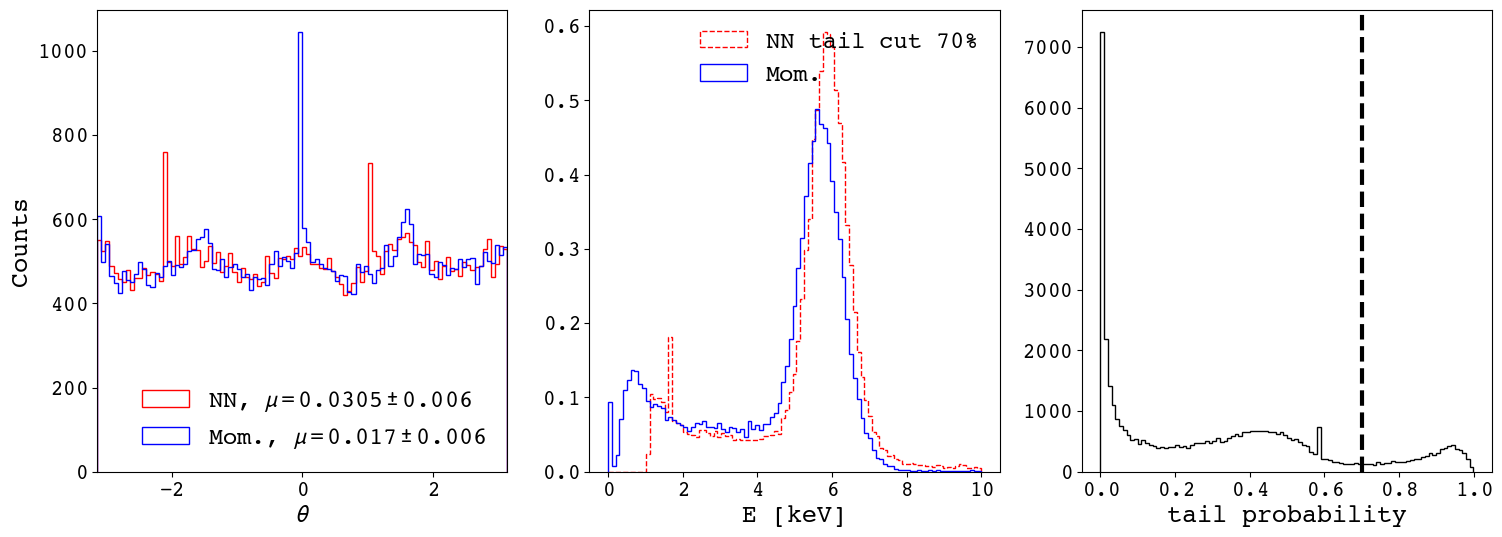

In [29]:
fig, (ax,ax2,ax3) = plt.subplots(figsize=(18,6), ncols=3)

print("(mu, theta0, Neff, mu_err, theta0_err)")

mu, theta0, Neff, mu_err, theta0_err = weighted_stokes(meas_results['NN_PHI'], error=True)

print(f"NN {mu:.4}, {theta0:.4}, {Neff:.4}, {mu_err:.4}, {theta0_err:.4},")
print(f"MDP99: {MDP99(Neff, mu):.4} \n")

mu_mom, theta0, Neff, mu_mom_err, theta0_err = weighted_stokes(meas_results['MOM_PHI'], error=True)

print(f"Mom {mu_mom:.4}, {theta0:.4}, {Neff:.4}, {mu_mom_err:.4}, {theta0_err:.4},")
print(f"MDP99: {MDP99(Neff, mu_mom):.4}")


h = ax.hist(meas_results['NN_PHI'], histtype='step', bins=100,color='r',label=f'NN, $\mu = {mu:.3} \pm {mu_err:.1}$')
h = ax.hist(meas_results['MOM_PHI'], histtype='step', bins=100,color='b',label=f'Mom., $\mu = {mu_mom:.3} \pm {mu_mom_err:.1}$')

ax.set_xlabel(r"$\theta$")
ax.set_ylabel("Counts")
ax.set_xlim(-np.pi,np.pi)

leg = ax.legend(loc = 4,)

# Apply a weighted analysis using optimal weights predicted by the NNs or moment ellipticities. 
print("\n Weighted:")
print("(mu, theta0, Neff, mu_err, theta0_err)")
mu, theta0, Neff, mu_err, theta0_err = weighted_stokes(meas_results['NN_PHI'], meas_results['NN_WEIGHT'], error=True)
print(f"NN {mu:.4}, {theta0:.4}, {Neff:.4}, {mu_err:.4}, {theta0_err:.4},")
print(f"MDP99: {MDP99(Neff, mu):.4} \n")
mu, theta0, Neff, mu_err, theta0_err = weighted_stokes(meas_results['MOM_PHI'], meas_results['MOM_ELLIP'], error=True)
print(f"Mom {mu:.4}, {theta0:.4}, {Neff:.4}, {mu_err:.4}, {theta0_err:.4},")
print(f"MDP99: {MDP99(Neff, mu):.4} \n")


##Energy resolution
cut = meas_results['P_TAIL'] <= 0.7
ebins = np.linspace(0, 10, 100)
h = ax2.hist(meas_results['NN_ENERGY'][cut], histtype='step', bins=ebins,color='r', ls='--',label=f'NN tail cut 70%', density=True)
h = ax2.hist(meas_results['MOM_ENERGY'], histtype='step', bins=ebins,color='b',label=f'Mom.', density=True)
ax2.set_xlabel("E [keV]")
leg = ax2.legend()

##Ptail
h = ax3.hist(meas_results['P_TAIL'], histtype='step', bins=100, color='k')
ax3.set_xlabel("tail probability")
ax3.axvline(0.7, ls='--', color='k')